# Day 42

I'm continuing with my fantasy draft analysis which was last worked on Day 39.  

Query Updates
- Changed the logic for injuries. Removed instances where players were counted as injured but were really resting
- Replaced null values for `weeks_injured` with 0 using `COALESCE()`

In [1]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_palette('deep')

# Create database connection
conn = sqlite3.connect('../../data/db/database.db')

## Query the Data

In [2]:
query = """
WITH adp_cleaned AS (
    SELECT
        scoring,
        season,
        teams AS league_size,
        CASE
            WHEN player_id = 2071 AND name = 'CJ Anderson' THEN 'C.J. Anderson'
            ELSE name
        END AS player_name,
        position AS pos,
        /*
        ADP dataset has the most recent team that a player has played for, regardless of season.
        So I'll need to update teams for certain player-season combinations in order to join
        against the nflverse data which contains the player's fantasy points by season
        */
        CASE
            WHEN player_id = 1347 AND name = 'Chris Johnson' THEN 'TEN'
            WHEN player_id = 1340 AND name = 'Fred Jackson' AND season < 2015 THEN 'BUF'
            WHEN player_id = 1340 AND name = 'Fred Jackson' AND season = 2015 THEN 'SEA'
            WHEN player_id = 1728 AND name = 'C.J. Spiller' AND season < 2014 THEN 'BUF'
            WHEN player_id = 1728 AND name = 'C.J. Spiller' AND season = 2015 THEN 'NO'
            WHEN player_id = 649 AND name = 'Maurice Jones-Drew' AND season < 2014 THEN 'JAX'
            ELSE team
        END AS team,
        adp_formatted,
        round,
        pick
    FROM adp),
season_summary AS (
    SELECT
        player_id,
        -- Data Cleaning for future join against ADP table
        CASE
            WHEN player_display_name = "Le'Veon Bell" THEN "LeVeon Bell"
            WHEN player_display_name = "Odell Beckham" THEN "Odell Beckham Jr"
            WHEN player_display_name = "Mike Vick" THEN "Michael Vick"
            WHEN player_display_name = "DK Metcalf" THEN "D.K. Metcalf"
            ELSE player_display_name
        END AS player_name,
        season,
        -- Data Cleaning for future join against ADP table
        CASE 
            WHEN player_id = "00-0029675" AND player_display_name = "Trent Richardson" THEN "RB"
            ELSE position
        END AS pos,
        -- Data Cleaning for future join against ADP table
        CASE
            WHEN recent_team = 'LA' THEN 'LAR'
            ELSE recent_team
        END AS team,
        ROUND(SUM(fantasy_points), 2) AS tot_pts,
        ROUND(SUM(fantasy_points_ppr), 2) AS tot_pts_ppr
    FROM 
        /* 
        The ADP table that I will eventually join against has the last team a player
        played for in a given season. In the case of players that were traded 
        at least once in a season, if I group by player name with player-week records in
        ascending order (by week) I'll get their earliest team. So I need to order by 
        most recent week to get the last team they played for when I aggregate.
        */
        (
            SELECT  *
            FROM weekly
            ORDER BY week DESC 
        ) AS weekly
    WHERE season_type = 'REG' 
        AND player_display_name IS NOT NULL
    GROUP BY player_id, player_display_name, season),
rankings AS (
    SELECT
        *,
        RANK() OVER(PARTITION BY season ORDER BY tot_pts DESC) AS r_pts,
        RANK() OVER(PARTITION BY season ORDER BY tot_pts_ppr DESC) AS r_pts_ppr
    FROM season_summary), 
joined AS (   
    SELECT
        adp_cleaned.*, 
        rankings.*, 
        weeks_injured
    FROM adp_cleaned
    LEFT JOIN rankings
        ON rankings.player_name = adp_cleaned.player_name
        AND rankings.season = adp_cleaned.season
        -- Additional join keys added in case multiple players have same name
        AND rankings.pos = adp_cleaned.pos
        AND rankings.team = adp_cleaned.team
    LEFT JOIN (
        SELECT *, COUNT(*) AS weeks_injured
        FROM injuries
        WHERE practice_status LIKE 'OUT%'
            OR (practice_status LIKE 'Did Not Participate%'
                -- Need to check for players who were just resting
                AND LOWER(practice_primary_injury) NOT LIKE '%not injury related%') 
        GROUP BY season, full_name, team, position
    ) AS injuries
        ON injuries.season = adp_cleaned.season
        AND injuries.full_name = adp_cleaned.player_name
        -- Additional join keys added in case multiple players have same name
        AND injuries.team = adp_cleaned.team
        AND injuries.position = adp_cleaned.pos),
first_and_second_round_picks AS (
    SELECT
        scoring,
        season,
        league_size,
        player_id,
        player_name,
        pos,
        team,
        adp_formatted,
        tot_pts_ppr,
        -- r_pts,
        r_pts_ppr,
        COALESCE(weeks_injured, 0) AS weeks_injured  -- replace NULL values with 0
    FROM joined
    WHERE round = 1
        OR round = 2)
SELECT * 
FROM first_and_second_round_picks
WHERE scoring = 'ppr'
    --AND league_size = 10
"""

df = pd.read_sql(query, conn)
df.head(10)

,scoring,season,league_size,player_id,player_name,pos,team,adp_formatted,tot_pts_ppr,r_pts_ppr,weeks_injured
0,ppr,2010,10,00-0026164,Chris Johnson,RB,TEN,1.01,272.90,17.0,0
1,ppr,2010,10,00-0025394,Adrian Peterson,RB,MIN,1.02,275.90,15.0,0
2,ppr,2010,10,00-0026195,Ray Rice,RB,BAL,1.03,276.60,14.0,0
3,ppr,2010,10,00-0024275,Maurice Jones-Drew,RB,JAX,1.05,234.10,35.0,2
4,ppr,2010,10,00-0022044,Andre Johnson,WR,HOU,1.05,256.60,23.0,3
5,ppr,2010,10,00-0023500,Frank Gore,RB,SF,1.06,202.50,56.0,0
6,ppr,2010,10,00-0023459,Aaron Rodgers,QB,GB,1.08,304.48,4.0,1
7,ppr,2010,10,00-0011754,Randy Moss,WR,TEN,1.08,97.30,178.0,0
8,ppr,2010,10,00-0022821,Michael Turner,RB,ATL,1.09,225.60,42.0,0
9,ppr,2010,10,00-0020498,Reggie Wayne,WR,IND,2.01,280.50,12.0,1


In [4]:
df[df['r_pts_ppr'].isnull()]

,scoring,season,league_size,player_id,player_name,pos,team,adp_formatted,tot_pts_ppr,r_pts_ppr,weeks_injured
161,ppr,2018,10,None,LeVeon Bell,RB,PIT,1.03,NaN,NaN,0
306,ppr,2012,12,None,Steven Jackson,RB,ATL,2.09,NaN,NaN,0
433,ppr,2018,12,None,LeVeon Bell,RB,PIT,1.03,NaN,NaN,0


This is the season where Le'Veon Bell sat out for the entire season. Fantasy managers who picked him in the first round ended up losing out big time!

In [6]:
df.describe().round(2)

,season,league_size,tot_pts_ppr,r_pts_ppr,weeks_injured
count,528.00,528.00,525.00,525.00,528.00
mean,2015.61,11.08,232.56,66.98,1.11
std,3.44,1.00,90.25,83.85,1.80
min,2010.00,10.00,9.00,1.00,0.00
25%,2013.00,10.00,178.20,13.00,0.00
50%,2016.00,12.00,234.10,38.00,0.00
75%,2019.00,12.00,303.10,84.00,2.00
max,2021.00,12.00,471.20,434.00,10.00


## Cleaning

In [7]:
def get_pick(row):
    round = int(row['adp_formatted'].split('.')[0])
    
    if row['league_size'] == 10:
        if round == 1:
            pick = int(row['adp_formatted'].split('.')[1])
        elif round == 2:
            pick = (round + int(row['adp_formatted'].split('.')[1])) + 8
    elif row['league_size'] == 12:
        if round == 1:
            pick = int(row['adp_formatted'].split('.')[1])
        elif round == 2:
            pick = (round + int(row['adp_formatted'].split('.')[1])) + 10

    return pick

df['pick'] = df.apply(lambda row: get_pick(row), axis=1)

## Exploratory Data Analysis

In [8]:
order = list(df.adp_formatted.unique())
order.sort()
order[:5]

['1.01', '1.02', '1.03', '1.04', '1.05']

In [9]:
# Remove outliers (players with season-ending injuries that happened early into the season)
df_rm_outliers = df.query("r_pts_ppr < 100")

In [10]:
df_rm_outliers.describe().round(2)

,season,league_size,tot_pts_ppr,r_pts_ppr,weeks_injured,pick
count,411.00,411.00,411.00,411.00,411.00,411.00
mean,2015.54,11.08,268.74,32.15,0.70,11.56
std,3.49,1.00,61.48,25.81,1.12,6.28
min,2010.00,10.00,158.40,1.00,0.00,1.00
25%,2013.00,10.00,221.40,10.50,0.00,6.00
50%,2016.00,12.00,261.60,26.00,0.00,11.00
75%,2019.00,12.00,312.72,49.50,1.00,17.00
max,2021.00,12.00,471.20,99.00,4.00,24.00


In [11]:
df_rm_outliers.query("weeks_injured > 3")

,scoring,season,league_size,player_id,player_name,pos,team,adp_formatted,tot_pts_ppr,r_pts_ppr,weeks_injured,pick
53,ppr,2012,10,00-0027656,Rob Gronkowski,TE,NE,2.07,198.0,64.0,4,17
88,ppr,2014,10,00-0027942,A.J. Green,WR,CIN,2.01,205.3,59.0,4,11
109,ppr,2015,10,00-0025389,Calvin Johnson,WR,DET,2.03,261.4,29.0,4,13
122,ppr,2016,10,00-0027942,A.J. Green,WR,CIN,1.06,186.4,86.0,4,6
140,ppr,2017,10,00-0027793,Antonio Brown,WR,PIT,1.04,310.3,5.0,4,4
183,ppr,2019,10,00-0031381,Davante Adams,WR,GB,1.06,212.7,67.0,4,6
205,ppr,2020,10,00-0036360,Clyde Edwards-Helaire,RB,KC,1.06,176.0,87.0,4,6
302,ppr,2012,12,00-0027656,Rob Gronkowski,TE,NE,2.05,198.0,64.0,4,17
343,ppr,2014,12,00-0027942,A.J. Green,WR,CIN,1.11,205.3,59.0,4,11
368,ppr,2015,12,00-0025389,Calvin Johnson,WR,DET,2.01,261.4,29.0,4,13


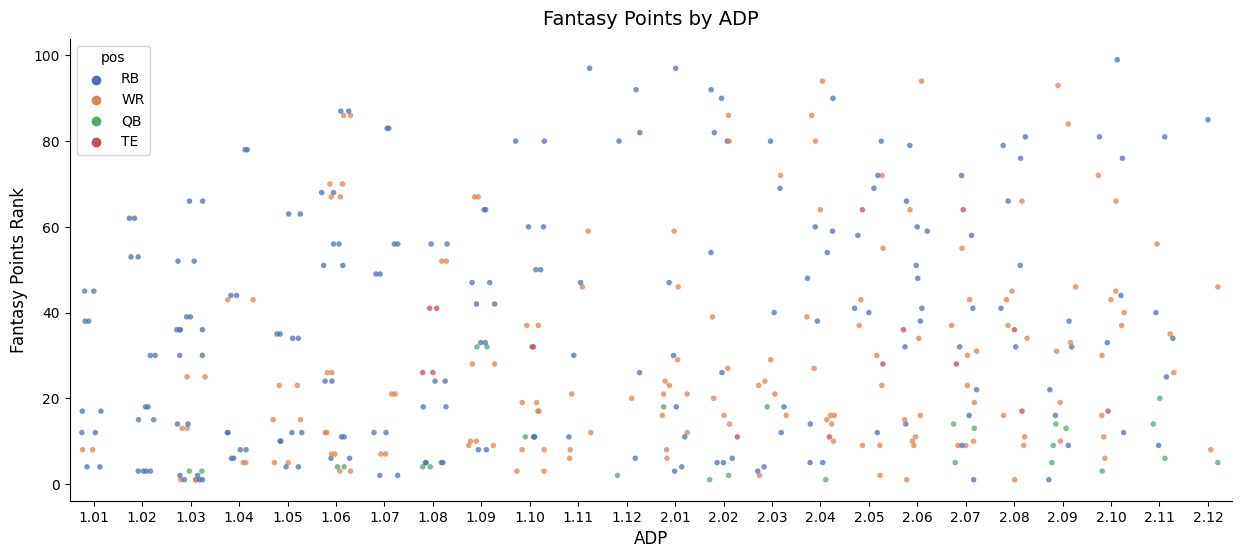

In [12]:
# Change plot size
plt.figure(figsize = (15, 6))

g = sns.stripplot(data=df_rm_outliers,
                  x='adp_formatted',
                  y='r_pts_ppr',
                  jitter=0.30,
                  size=4,
                  alpha=0.75,
                  hue='pos',
                  order=order)

# Add labels and title
g.set_xlabel("ADP", size=12)
g.set_ylabel("Fantasy Points Rank", size=12)
g.set_title("Fantasy Points by ADP", size=14, pad=10)

sns.despine()
plt.show()

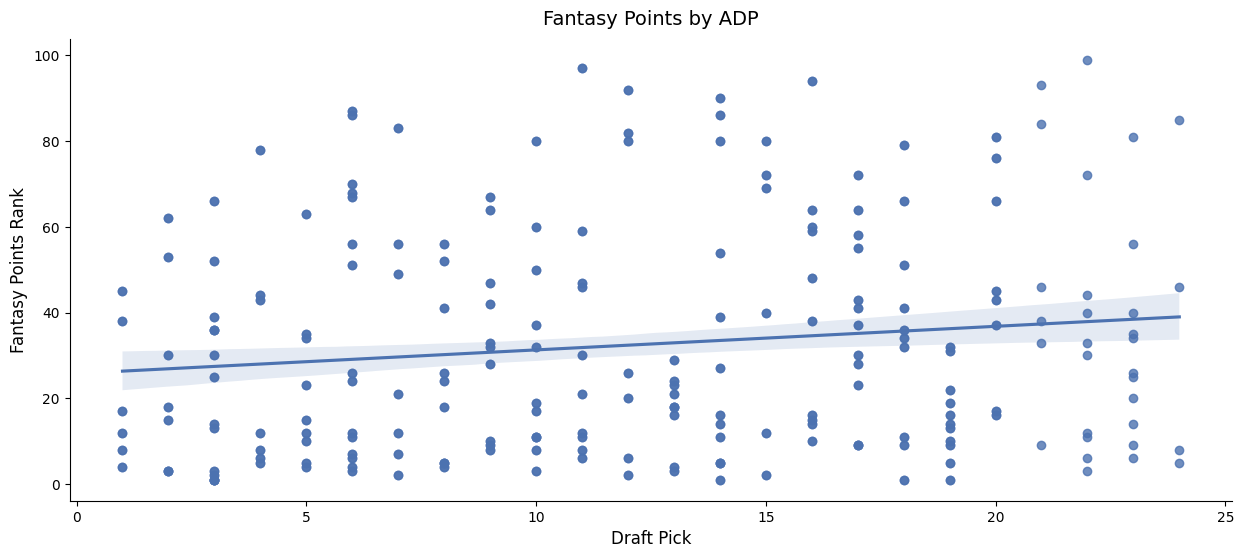

In [15]:
# Change plot size
plt.figure(figsize = (15, 6))

g = sns.regplot(data=df_rm_outliers,
            x='pick',
            y='r_pts_ppr')

# Add labels and title
g.set_xlabel("Draft Pick", size=12)
g.set_ylabel("Fantasy Points Rank", size=12)
g.set_title("Fantasy Points by ADP", size=14, pad=10)

sns.despine()
plt.show()

In [16]:
# Check correlation coefficient
df_rm_outliers.pick.corr(df_rm_outliers.r_pts_ppr).round(2)

0.13

There is a very weak positive correlation between draft pick and end of season fantasy points ranking, at least for the first two rounds of a fantasy draft

In [17]:
# Number of players by ADP
df_rm_outliers['adp_formatted'].value_counts().sort_index()

1.01    12
1.02    14
1.03    28
1.04    14
1.05    18
1.06    30
1.07    14
1.08    18
1.09    20
1.10    22
1.11    10
1.12     7
2.01    19
2.02    19
2.03    15
2.04    22
2.05    18
2.06    20
2.07    23
2.08    18
2.09    17
2.10    18
2.11    11
2.12     4
Name: adp_formatted, dtype: int64

In [18]:
# Number of players by ADP
df_rm_outliers['pick'].value_counts().sort_index()

1     12
2     14
3     28
4     14
5     18
6     30
7     14
8     18
9     20
10    22
11    20
12    14
13    18
14    24
15    12
16    20
17    24
18    20
19    22
20    16
21     6
22    10
23    11
24     4
Name: pick, dtype: int64

The sample size is small since I only have data going back to 2010 (11 seasons) and two league sizes (10 and 12 team leagues). Not to mention, some adp levels that are unique to a certain size of league (picks 11 and 12) tend to have even less data.  

In order to run any kind of analysis I need bigger sample sizes. One way to do this is to run bootstrap simulations to simulate more seasons. I'll switch to `pick` since that will help fill out picks 11 and 12. Picks 23 and 24 will still have low counts since those are specific to just 12 team leagues (if I stick to looking at only the first two rounds).  

Let's try creating bootstrap samples and see how it goes.

## Bootstrap Simulations

In [19]:
def generate_bootstrap_distribution(n, df):
    
    # Get sample means
    bootstrap_dist = []
    for i in range(n):
        bootstrap_dist.append(
            # Get point estimate
            np.mean(
                # Resample
                df.sample(frac=1, replace=True)['r_pts_ppr']
            )
        )
    return bootstrap_dist

In [20]:
bootstrap_results = {}

for pick in range(1, 25):
    bootstrap_results[str(pick)] = generate_bootstrap_distribution(10000, df_rm_outliers.query(f"pick == {pick}"))

df_boot_results = pd.DataFrame(bootstrap_results)

In [21]:
df_boot_results.describe()

,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,20.690100,26.282000,22.816750,28.006100,22.337928,38.523783,32.936686,25.702822,33.950480,29.854473,...,45.853533,41.859730,39.053146,35.923845,15.624205,47.612319,50.488233,34.958520,31.503100,35.856650
std,4.508210,5.869657,3.833437,6.898896,4.246004,5.565386,7.525100,4.444725,4.539089,5.026535,...,8.852536,5.942925,4.028082,5.250403,1.991590,5.828308,12.097106,9.242699,6.326663,16.320875
min,7.666667,5.785714,7.750000,7.071429,8.000000,20.166667,8.214286,9.388889,18.700000,13.772727,...,14.833333,19.400000,25.541667,12.400000,8.727273,27.312500,13.000000,9.100000,13.454545,5.000000
25%,17.500000,22.285714,20.178571,23.071429,19.444444,34.766667,27.642857,22.666667,30.850000,26.318182,...,39.916667,37.750000,36.333333,32.350000,14.272727,43.687500,42.000000,28.500000,27.000000,25.750000
50%,20.583333,26.071429,22.750000,27.928571,22.166667,38.466667,32.714286,25.666667,33.900000,29.636364,...,45.833333,41.750000,39.000000,35.850000,15.590909,47.562500,50.500000,34.600000,31.090909,36.000000
75%,23.666667,30.285714,25.392857,32.785714,25.111111,42.233333,37.928571,28.611111,37.000000,33.272727,...,52.083333,45.800000,41.833333,39.412500,16.965909,51.453125,58.833333,41.100000,35.636364,46.250000
max,39.250000,46.928571,36.714286,58.000000,40.222222,61.166667,63.857143,41.611111,50.550000,51.136364,...,73.416667,64.900000,56.375000,56.250000,23.681818,69.437500,91.500000,70.500000,60.181818,85.000000


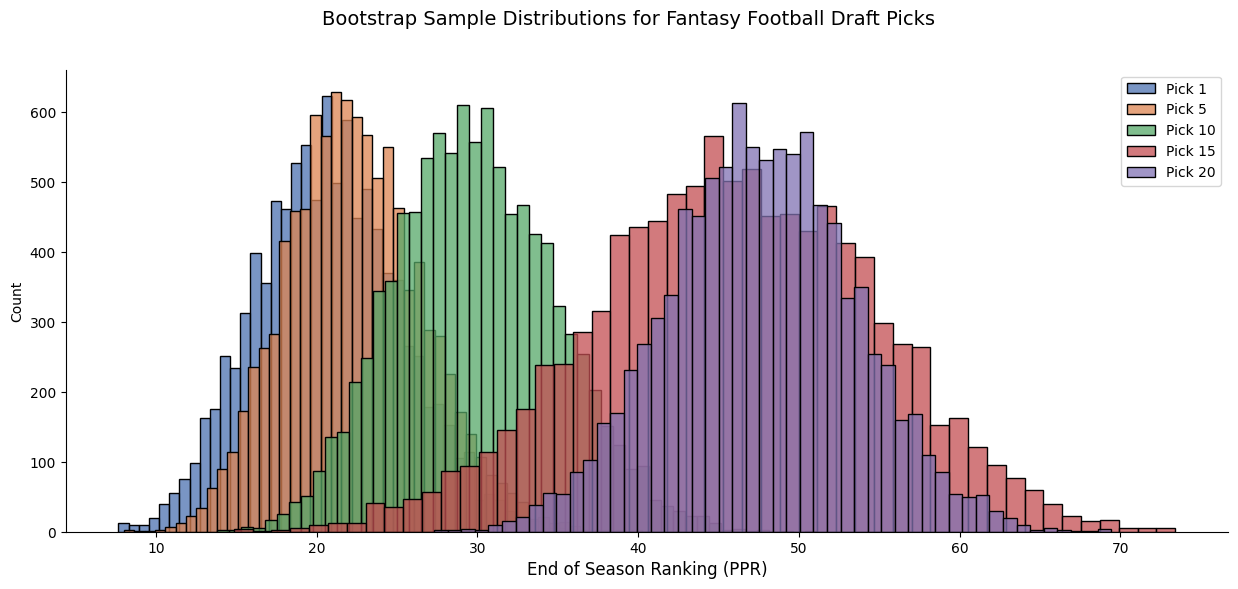

In [24]:
# Change plot size
fig, ax = plt.subplots(figsize = (15, 6))

# Confirm sample means are normally distributed
g1 = sns.histplot(df_boot_results['1'], bins=50, alpha=0.75, label='Pick 1', ax=ax, legend=True)
g2 = sns.histplot(df_boot_results['5'], bins=50, alpha=0.75, label='Pick 5', legend=False)
g3 = sns.histplot(df_boot_results['10'], bins=50, alpha=0.75, label='Pick 10', legend=False)
g4 = sns.histplot(df_boot_results['15'], bins=50, alpha=0.75, label='Pick 15', legend=False)
g5 = sns.histplot(df_boot_results['20'], bins=50, alpha=0.75, label='Pick 20', legend=False)

plt.xlabel("End of Season Ranking (PPR)", size=12)
fig.suptitle('Bootstrap Sample Distributions for Fantasy Football Draft Picks', size=14)

# Correct duplicate labels appearing in the legend
handles, labels = ax.get_legend_handles_labels()

h = []
l = []

for i in range(1,10,2):
	h.append(handles[i])
	l.append(labels[i])

plt.legend(handles=h, labels=l)

sns.despine()
plt.show()

The bootstrap distributions make it easy to see the difference between not only the performances of players taken in the 1st and 2nd rounds, but also players taken within the 1st round – there's a noticeable drop off between Picks 1-5 and Pick 10.